# EWC example on MNIST dataset

    Potapov Anatoly 4015 MIPT 2017

based on https://deepmind.com/blog/enabling-continual-learning-in-neural-networks/

and http://www.pnas.org/content/early/2017/03/13/1611835114.abstract

    The task is to demonstrate that EWC technic published in recent DeepMind paper helps with catastrophical forgetting.

We present an algorithm, EWC, that allows knowledge of previous
tasks to be protected during new learning, thereby avoiding
catastrophic forgetting. It does so by selectively decreasing
the plasticity of weights and thus has certain parallels with
neurobiological models of synaptic consolidation (15, 16). We
implement EWC as a soft, quadratic constraint whereby each
weight is pulled back toward its old values by an amount
proportional to its importance for performance on previously
learned tasks. In analytically tractable settings, we demonstrate
that EWC can protect network weights from interference and
thus increase the fraction of memories retained over plain
gradient descent. To the extent that tasks share structure, networks
trained with EWC reuse shared components of the network.
We further show that EWC can be effectively combined
with deep neural networks to support continual learning
in challenging reinforcement learning scenarios, such as Atari
2600 games.

The EWC algorithm can be grounded in Bayesian approaches
to learning. Formally, when there is a new task to be learned, the
network parameters are tempered by a prior which is the posterior
distribution on the parameters given data from the previous
task(s). This enables fast learning rates on parameters that are
poorly constrained by the previous tasks and slow learning rates for those that are crucial.
    

Основная идея состоит во введении квадратичного штрафа за изменение весов, от которых зависит точность на ранее изученных задачах:

$$
L(\theta) = L_B(\theta) +  \sum_{i} \frac{ewc}{2} \cdot F_i (\theta_i - \theta^*_{A, i})^2
$$

$$
\alpha \equiv p[ data | theory ] 
$$
Функция правдоподобия

$$
F_i = \frac{\partial^2 \alpha}{\partial \theta_i \partial \theta_i} = \frac{\partial^2 L_A(\theta, data)}{\partial \theta_i \partial \theta_i}
$$
Где $F_i$ - диагональные элементы матрицы Фишера.

Вычисление только диагональных элементов матрицы Фишера F линейно по колличеству параметров и по колличеству примеров в обучающей выборке.

In [1]:
from __future__ import print_function

In [2]:
import numpy as np
import tensorflow as tf

### Load and format data

In [3]:
import os 
import sys
import gzip
import pickle
from urllib import urlretrieve

def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename)
        print('\nDownload Complete!')
    
    statinfo = os.stat(dest_filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception(
            'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

data_root = 'data/'
url = 'http://deeplearning.net/data/mnist/'
train_filename = maybe_download('mnist.pkl.gz', 16168813)

Found and verified data/mnist.pkl.gz


In [4]:
with gzip.open('data/mnist.pkl.gz', 'rb') as f:
    (X_train, y_train), (X_val, y_val), (X_test, y_test) =  pickle.load(f)

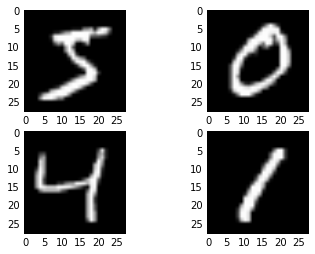

In [5]:
import matplotlib.pyplot as plt
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2].reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3].reshape(28,28), cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

### Y - to one hot

In [6]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

In [7]:
X_val, y_val  = reformat(X_val, y_val.reshape(10000,))
print(X_val.shape, y_val.shape)

(10000, 784) (10000, 10)


In [8]:
X_train, y_train  = reformat(X_train, y_train.reshape(50000,))
print(X_train.shape, y_train.shape)

(50000, 784) (50000, 10)


# Tensorflow MLP

In [9]:
batch_size = 128

In [10]:
class Model:

    def __init__(self, l1 = 128, l2 = 128):
        
        # Network Parameters
        n_hidden_1 = l1 # 1st layer number of features
        n_hidden_2 = l2 # 2nd layer number of features
        n_input = 784 # MNIST data input (img shape: 28*28)
        n_classes = 10 # MNIST total classes (0-9 digits)
        
        # tf Graph input
        self.tf_x = tf.placeholder("float", [None, n_input])
        self.tf_y = tf.placeholder("float", [None, n_classes])
        self.ewc = tf.constant(1e15)
        self.l = tf.constant(0.0)
        
        # Create model
        def multilayer_perceptron(x, weights):
            # Hidden layer with RELU activation
            layer_1 = tf.matmul(x, weights['h1'])
            layer_1 = tf.nn.relu(layer_1)
            # Hidden layer with RELU activation
            layer_2 = tf.matmul(layer_1, weights['h2'])
            layer_2 = tf.nn.relu(layer_2)
            # Output layer with linear activation
            out_layer = tf.matmul(layer_2, weights['out'])
            return out_layer
        
        self.multilayer_perceptron = multilayer_perceptron
        
        # Store layers weight
        self.weights = {
            'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
            'h1e': tf.Variable(tf.random_normal([n_input, n_hidden_1]), trainable=False),
            'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
            'h2e': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]), trainable=False),
            'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes])),
            'oute': tf.Variable(tf.random_normal([n_hidden_2, n_classes]), trainable=False)
        }

        self.fisher = {
            'h1': tf.Variable(tf.zeros([n_input, n_hidden_1])),
            'h2': tf.Variable(tf.zeros([n_hidden_1, n_hidden_2])),
            'out': tf.Variable(tf.zeros([n_hidden_2, n_classes]))
        }

        # Construct model
        self.pred = self.multilayer_perceptron(self.tf_x, self.weights)

        # Define loss and optimizer
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.pred, labels=self.tf_y)) 
        cost = cost + self.l*tf.nn.l2_loss(self.weights['h1']) + self.l*tf.nn.l2_loss(self.weights['h2']) + self.l*tf.nn.l2_loss(self.weights['out'])
        self.cost = cost
        
        self.optimizer = tf.train.AdamOptimizer(0.001)
        self.minimize_cost = self.optimizer.minimize(self.cost) 
        
        self.grads = self.optimizer.compute_gradients(self.cost, [self.weights['h1'], self.weights['h2'], self.weights['out']]) 

        ewc_cost = self.ewc * tf.nn.l2_loss(tf.multiply(self.fisher['h1'], tf.subtract(self.weights['h1'], self.weights['h1e'])))
        ewc_cost = ewc_cost + self.ewc * tf.nn.l2_loss(tf.multiply(self.fisher['h2'], tf.subtract(self.weights['h2'], self.weights['h2e'])))
        ewc_cost = ewc_cost + self.ewc * tf.nn.l2_loss(tf.multiply(self.fisher['out'], tf.subtract(self.weights['out'], self.weights['oute'])))
        self.ewc_cost = ewc_cost
        
        self.objective = self.cost + self.ewc_cost
        self.minimize_cost_ewc = self.optimizer.minimize(self.objective)
        
        # Initializing the variables
        self.init = tf.global_variables_initializer()        
     

In [13]:
tf.trainable_variables()

[]

### Batch generator

In [14]:
var = 10
n_perm = 250
from_ind = [np.random.randint(low=0, high=784, size=n_perm) for i in range(var)]
to_ind = [np.random.randint(low=0, high=784, size=n_perm) for i in range(var)]

In [15]:
def permutation(X_inp, perm):
    X = np.copy(X_inp)
    n, d = X.shape
    a = from_ind[perm]
    b = to_ind[perm]
    for i in range(n_perm):
        tmp = X[:,a[i]]
        X[:,a[i]] = X[:,b[i]]
        X[:,b[i]] = tmp
    return X

In [16]:
import matplotlib.pyplot as plt
def plot(X):# plot 4 images as gray scale
    plt.subplot(221)
    plt.imshow(X[0].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.subplot(222)
    plt.imshow(X[1].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.subplot(223)
    plt.imshow(X[2].reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.subplot(224)
    plt.imshow(X[3].reshape(28,28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()

In [17]:
batch_size = 128

def batch_generator(X, y, batch_size):
    l = X.shape[0]
    def another():
        indexes = np.random.randint(low=0, high=l, size=batch_size)
        return [
            X.take(indexes, axis=0),
            y[indexes]
        ]
            
    while True:
        yield another()
        
    
batches = batch_generator(X_train, y_train , batch_size=batch_size)
x, y = batches.next()
print(x.shape, y.shape)

(128, 784) (128, 10)


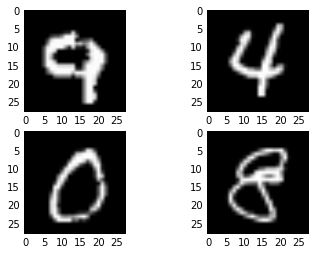

In [18]:
X,y = batches.next()
plot(X)

### Introducing permutations

In [19]:
X1_train = permutation(X_train, 1)
X2_train = permutation(X_train, 2)
X3_train = permutation(X_train, 3)
X4_train = permutation(X_train, 4)
X5_train = permutation(X_train, 5)

batches1 = batch_generator(X1_train, y_train , batch_size=batch_size)
batches2 = batch_generator(X2_train, y_train , batch_size=batch_size)
batches3 = batch_generator(X3_train, y_train , batch_size=batch_size)
batches4 = batch_generator(X4_train, y_train , batch_size=batch_size)
batches5 = batch_generator(X5_train, y_train , batch_size=batch_size)

b_list = [batches1, batches2, batches3, batches4, batches5]

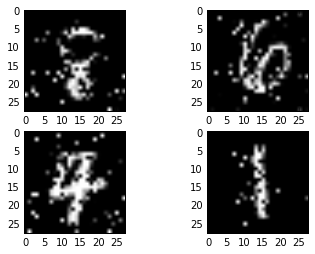

In [20]:
X, y = batches1.next()
plot(X)

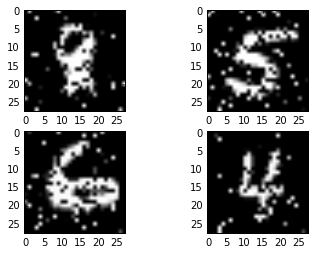

In [21]:
X, y = batches2.next()
plot(X)

In [22]:
model = Model(128,128)
#tf.reset_default_graph()
sess = tf.Session()
sess.run(model.init)
acc_track = [[],[],[]]

### Helper functions for training

In [23]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
                    / predictions.shape[0])

In [26]:
def restore(sess):
    ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoint_directory/{}'.format(model_name)))
    if ckpt and ckpt.model_checkpoint_path:
        saver.restore(sess, ckpt.model_checkpoint_path)

In [27]:
from ipywidgets import IntProgress
from IPython.display import display

def progress(max):
    p = IntProgress(max = max)
    p.description = 'Running'
    display(p)
    return p


In [41]:
max_steps = 3001
period_print = 500
period_stat = 100

def train(model, batches_list, EWC = False, stat = False):
    
    acc_track = [[],[],[],[],[]]
    p = progress(max_steps*len(batches_list))
    pr = 0
    
    for ind, batches in enumerate(batches_list):
        print("Training on batches{0}\n".format(ind+1))
        try:
            for step in range(max_steps):
                
                pr = pr+1
                p.value = pr
                
                X, y = batches.next()
                train_d = {model.tf_x : X, model.tf_y : y}

                if EWC ==  False:
                    _ = sess.run(model.minimize_cost, feed_dict=train_d)
                if EWC ==  True:
                    _ = sess.run(model.minimize_cost_ewc, feed_dict=train_d)

                if step % period_stat == 0:
                    acc_track[0].append(test_acc(model, X1_train, y_train))
                    acc_track[1].append(test_acc(model, X2_train, y_train))
                    acc_track[2].append(test_acc(model, X3_train, y_train))   
                    acc_track[3].append(test_acc(model, X4_train, y_train))
                    acc_track[4].append(test_acc(model, X5_train, y_train))

                if (step % period_print == 0) and (stat == True):
                    test_d = {model.tf_x : X, model.tf_y : y}
                    l,ll, train_pred = sess.run([model.cost, model.ewc_cost, model.pred], feed_dict=test_d)
                    print(
                        "Step {0}: \n loss: {1} {2} \n minibatch acc: {3}% \n".format(
                            step,
                            l,
                            ll,
                            accuracy(train_pred, y)
                        )
                    )
            set_constraint(model, X, y)

        except KeyboardInterrupt:
            set_constraint(model, X, y)
            print('training interrupted')

    return acc_track

In [29]:
def test_acc(model, X, y):
    #X, y = batches.next()
    test_d = {model.tf_x : X, model.tf_y : y}
    prediction = sess.run([model.pred], feed_dict=test_d)
    return accuracy(prediction[0], y)              

In [30]:
def get_gradient(model, batches):
    X, y = batches.next()
    test_d = {model.tf_x : X, model.tf_y : y}
    gradient = sess.run([model.grads], feed_dict=test_d)
    return gradient

In [38]:
# Привязать к данным
def set_constraint(model, X, y):
    # Вычисляем Градиент по весам
    test_d = {model.tf_x : X, model.tf_y : y}
    g = sess.run([model.grads], feed_dict=test_d)
    #return gradient
    g1, w1 = g[0][0]
    g2, w2 = g[0][1]
    g3, w3 = g[0][2]
    # Забираем старые матрицы фишера
    # Возводим в квадрат
    with sess.as_default():
        f1 = 0.3 * np.square(g1) + 0.7 * model.fisher['h1'].eval()
        f2 = 0.3 * np.square(g2) + 0.7 * model.fisher['h2'].eval()
        f3 = 0.3 * np.square(g3) + 0.7 * model.fisher['out'].eval()

    #print(np.max(f1),np.max(f2),np.max(f3))
    with sess.as_default():
        # Обновляем коэффициенты матрицы фишера в графе
        model.fisher['h1'].assign(f1).eval()
        model.fisher['h2'].assign(f2).eval()
        model.fisher['out'].assign(f3).eval()
        # Обновляем центральные веса в графе
        model.weights['h1e'].assign(w1).eval()
        model.weights['h2e'].assign(w2).eval()
        model.weights['oute'].assign(w3).eval()

In [121]:
def plot(acc_track, title):
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.rc("font", size=10)
    fig = plt.figure()
    fig.suptitle(title, fontsize=14)
    axes = plt.gca()
    axes.set_ylim([0,100])
    l = len(acc_track[0])
    plt.plot(range(l), acc_track[0], label='permutation1')
    plt.plot(range(l), acc_track[1], label='permutation2')
    plt.plot(range(l), acc_track[2], label='permutation3')
    plt.plot(range(l), acc_track[3], label='permutation4')
    plt.plot(range(l), acc_track[4], label='permutation5')
    plt.ylabel('accuracy, %')
    plt.xlabel('number of training batches x100')
    plt.legend(loc=4, borderaxespad=0.)
    plt.show()

## Training

### Описание:
batches1 - batches5 - изображения из датасета MNIST с различными шумами ( в каждом - некоторый фиксированный случайный набор пар пикселей, в каждой паре пиксели меняются местами ).

Сеть - с двумя скрытыми слоями без байесов, активации - ReLU.

Сеть последовательно обучается на батчах из batches1 - batches5, в поцессе обучения сети измеряется точность классификаци на batches1 - batches5.

В одном случае мы просто обучаем сеть последовательно, без исползования EWC, a во втором случае после окончания тренировке на одной задаче, происходит обновление коэффициетнов матрицы Фишера и равновесных весов по формуле: 

$$
F_{i+1} = 0.3 \cdot F_{new} + 0.7 \cdot F_i
$$
$$
h_{e(i+1)} = h_{i}
$$

Выполним несколько прогонов, последовательно уменьшая колличество нейронов на скрытых слоях в два раза.

(l1, l2) - колличество нейронов на первом и втором скрытом слое.

# 128

In [102]:
model = Model(128,128)
#tf.reset_default_graph()
sess = tf.Session()
sess.run(model.init)

In [103]:
acc1 = train(model, b_list)

Training on batches1

Training on batches2

Training on batches3

Training on batches4

Training on batches5



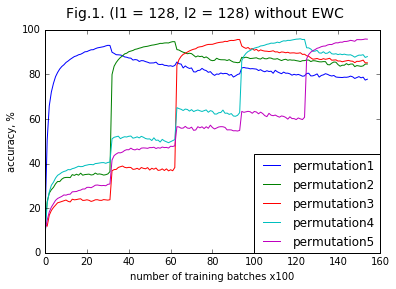

In [122]:
plot(acc1, title = "Fig.1. (l1 = 128, l2 = 128) without EWC ")

In [43]:
model = Model(128,128)
#tf.reset_default_graph()
sess = tf.Session()
sess.run(model.init)

In [ ]:
acc1_ewc = train(model, b_list, EWC=True)

Training on batches1

Training on batches2

Training on batches3

Training on batches5



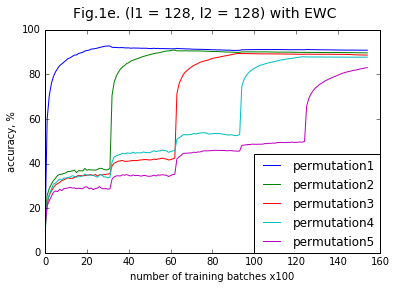

In [128]:
plot(acc1_ewc,  title = "Fig.1e. (l1 = 128, l2 = 128) with EWC ")

# 64

In [96]:
model = Model(64,64)
#tf.reset_default_graph()
sess = tf.Session()
sess.run(model.init)

In [97]:
acc2 = train(model, b_list)

Training on batches1

Training on batches2

Training on batches3

Training on batches4

Training on batches5



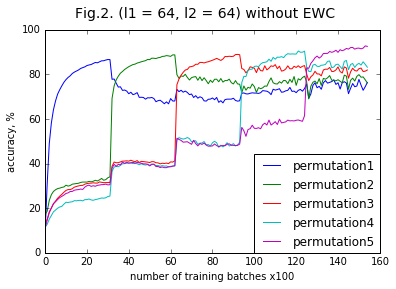

In [129]:
plot(acc2,  title = "Fig.2. (l1 = 64, l2 = 64) without EWC ")

In [51]:
model = Model(64,64)
#tf.reset_default_graph()
sess = tf.Session()
sess.run(model.init)

In [52]:
acc2_ewc = train(model, b_list, EWC=True)

Training on batches1

Training on batches2

Training on batches3

Training on batches4

Training on batches5



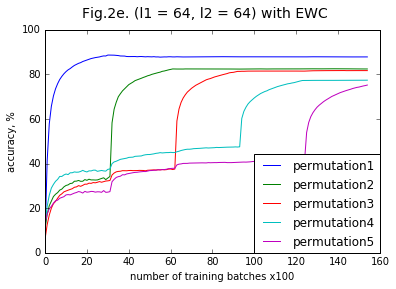

In [127]:
plot(acc2_ewc,  title = "Fig.2e. (l1 = 64, l2 = 64) with EWC ")

# 32

In [99]:
model = Model(32,32)
#tf.reset_default_graph()
sess = tf.Session()
sess.run(model.init)

In [100]:
acc3 = train(model, b_list)

Training on batches1

Training on batches2

Training on batches3

Training on batches4

Training on batches5



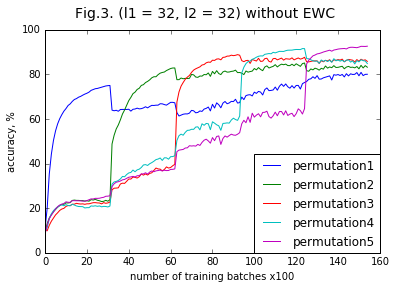

In [130]:
plot(acc3, title = "Fig.3. (l1 = 32, l2 = 32) without EWC ")

In [57]:
model = Model(32,32)
#tf.reset_default_graph()
sess = tf.Session()
sess.run(model.init)

In [58]:
acc3_ewc = train(model, b_list, EWC=True)

Training on batches1

Training on batches2

Training on batches3

Training on batches4

Training on batches5



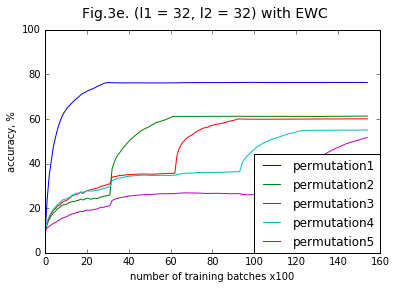

In [134]:
plot(acc3_ewc,  title = "Fig.3e. (l1 = 32, l2 = 32) with EWC ")

# Выводы

Техника EWC, предложенная DeepMind, позволяет эффективно бороться с забыванием нейросетями старых задач в процессе обучения новым. Это достигается путем избирательного ограничение learning rate на весах, играющих важную роль в решении предыдущих задач.


С уменьшением колличества нейронов на скрытых слоях уменьшается способность модели с EWC эффективно выучивать большое колличество задач.